In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline #pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE #for feature selection
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,StandardScaler
from sklearn.metrics import (f1_score,classification_report,
                             roc_auc_score,confusion_matrix,roc_curve,auc) # evaluating metrics
from sklearn.model_selection import KFold,RandomizedSearchCV ,cross_val_score,RepeatedStratifiedKFold
from sklearn.naive_bayes import GaussianNB
import gc

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/another-final-full-bureau-col/train.csv
/kaggle/input/another-final-full-bureau-col/test.csv
/kaggle/input/final-dataset/target.csv
/kaggle/input/final-dataset/train.csv
/kaggle/input/final-dataset/test.csv
/kaggle/input/best-validation-score/scikitlearn/default/1/Logistic Regression_model_fold_3.joblib


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
train =pd.read_csv('/kaggle/input/another-final-full-bureau-col/train.csv')

In [6]:
test=pd.read_csv('/kaggle/input/another-final-full-bureau-col/test.csv')

In [7]:
target=pd.read_csv('/kaggle/input/final-dataset/target.csv')

In [8]:
sk_id_curr=test.SK_ID_CURR.astype(int).tolist()

In [9]:
test.drop(columns='SK_ID_CURR', inplace=True)

# Hyperparameter tuning using optuna

In [10]:
def reduce_mem_usage(dataframe, verbose=True):
    m_start = dataframe.memory_usage().sum() / 1024 ** 2
    for col in dataframe.columns:
        col_type = dataframe[col].dtype
        if col_type != object:
            c_min = dataframe[col].min()
            c_max = dataframe[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    dataframe[col] = dataframe[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    dataframe[col] = dataframe[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    dataframe[col] = dataframe[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    dataframe[col] = dataframe[col].astype(np.int64)
            elif str(col_type)[:5] == 'float':
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    dataframe[col] = dataframe[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    dataframe[col] = dataframe[col].astype(np.float32)
                else:
                    dataframe[col] = dataframe[col].astype(np.float64)
    if verbose:
        m_end = dataframe.memory_usage().sum() / 1024 ** 2
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(
            m_end, 100 * (m_start - m_end) / m_start))

    return dataframe

train_df = reduce_mem_usage(train)
test_df = reduce_mem_usage(test)
target_df = reduce_mem_usage(target)

Mem. usage decreased to 492.69 Mb (67.5% reduction)
Mem. usage decreased to 122.35 Mb (67.7% reduction)
Mem. usage decreased to  0.23 Mb (87.5% reduction)


In [11]:
from sklearn.model_selection import StratifiedKFold
import joblib
import optuna
from tqdm import tqdm
from sklearn.model_selection import cross_val_score

In [12]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

a = skf.split(train_df, target_df)
for fold, (train_idx, test_idx) in enumerate(a):
    print(f"Fold {fold + 1}/5")
    if fold==3:
        X_train, X_test = train_df.iloc[train_idx], train_df.iloc[test_idx]
        y_train, y_test = target_df.iloc[train_idx], target_df.iloc[test_idx]

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


We have tested on all folds to find which have the highest ROC-AUC on the validation dataset. The result is fold 4. 

In [13]:
scaler= StandardScaler()
train_scaled=scaler.fit_transform(X_train)
test_scaled=scaler.transform(X_test)

In [ ]:
import optuna
from tqdm import tqdm
from sklearn.model_selection import cross_val_score

# Define the objective function
def objective(trial):
    # Define hyperparameter space
    # Define hyperparameter space

    hyperparameters = {
        'tol': trial.suggest_float('tol', 1e-07, 1e-06),  # Narrowed range
        'max_iter': trial.suggest_int('max_iter', 400,600),  # Reduced search range
        'class_weight': {
            0: trial.suggest_float(0, 0.8, 1.2),
            1: trial.suggest_float(1, 9, 12),
        },
    }

   # Train the model
    model = LogisticRegression(**hyperparameters)
    model.fit(train_scaled, y_train)
    preds = model.predict_proba(test_scaled)[:, 1]

    # Calculate the ROC-AUC score
    roc_auc = roc_auc_score(y_test, preds)
    return roc_auc

# Number of trials
n_trials = 50

# Create Optuna study
study = optuna.create_study(direction='maximize')

# Suppress Optuna logging (optional)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Progress bar with callback
with tqdm(total=n_trials) as pbar:
    def update_pbar(study, trial):
        pbar.update(1)

    # Parallel optimization
    study.optimize(objective, n_trials=n_trials, n_jobs=-1, callbacks=[update_pbar])

# Get the best hyperparameters
best_params = study.best_params
print('Best Hyperparameters:', best_params)

Each member of my team did the tuning on different search ranges of different parameters. They are 'tol', 'C', 'class_weight', 'max_iter', 'penalty', 'solver'. We removed penalty and solver because it made the run time much longer, and there are few options so we tried it out of this block instead. 

After many times trying we got the best search range of 'tol', 'C'. Therefore, we didn't search for C anymore.

# noted versions
1. tol=9.52616639602442e-06, max_iter=241, C=.010735977225980867, class_weight={0: 1.1430917511013274, 1: 11.622511128923657}, penalty='l1',solver='saga' gini=0.56219

2.  Best Hyperparameters: {'tol': 5.7666731227211045e-06, 'max_iter': 350, 'C': 0.001470331250903123} class_weight={0: 1.1430917511013274, 1: 11.622511128923657}, penalty='l1',solver='saga' gini=0.56004

3.  Best Hyperparameters: {'tol': 5.7666731227211045e-06, 'max_iter': 350, 'C': 0.001470331250903123} class_weight={0: 1.1430917511013274, 1: 10.622511128923657 gini=0.56056
4.  final_model = LogisticRegression(tol= 4.900820294708723e-07, max_iter=395, C=0.0009992559662549538, class_weight={0: 1.9430917511013274, 1: 11.622511128923657} gini=0.56104
5.  final_model = LogisticRegression(tol= 4.900820294708723e-07, max_iter=395, C=0.0009992559662549538, class_weight={0: 1.9430917511013274, 1: 11.622511128923657},     penalty='elasticnet',
    l1_ratio=0.5,
    solver='saga') gini=0.56130

6. (new dataset). final_model = LogisticRegression(tol= 4.900820294708723e-07, max_iter=395, C=0.0009992559662549538, class_weight={0: 1.9430917511013274, 1: 11.622511128923657} gini=0.56452
7. tol= 5e-07, max_iter=400, C=0.0001, class_weight={0: 1.9430917511013274, 1: 11.622511128923657} gini=0.56374
8. newest: tol=9.298138543068698e-07,max_iter= 554, class_weight={0: 1.1991839148693013,1: 9.231878884527436},C= 0.0009992559662549538,
                                penalty='l1',solver='saga' gini= 0.56447
9. tol=9.298138543068698e-07,max_iter= 554, class_weight={0: 1.1991839148693013,1: 9.231878884527436},C= 0.0009992559662549538,
                                penalty='elasticnet',l1_ratio=0.2,solver='saga'

gini = 0.56564

l1 0.3 gini=0.56476

l1=0.1 gini=0.56532

In [14]:
best_params1= {'tol':9.298138543068698e-07,'max_iter': 554, 'class_weight':{0: 1.1991839148693013,1: 9.231878884527436},'C': 0.0009992559662549538,
                                'penalty':'elasticnet','l1_ratio':0.2,'solver':'saga'}

best_params2= {'tol':9.298138543068698e-07,'max_iter': 554, 'class_weight':{0: 1.1991839148693013,1: 9.231878884527436},'C': 0.0009992559662549538,
                                'penalty':'elasticnet','l1_ratio':0.1,'solver':'saga'}


In [15]:
# Train final model
final_model = LogisticRegression(**best_params2)
final_model.fit(train_scaled, y_train)

# Validation metrics
roc_auc = roc_auc_score(y_test, final_model.predict_proba(test_scaled)[:, 1])
gini_index = 2 * roc_auc - 1

# Results
print('ROC-AUC on Validation Set:', roc_auc)
print('Gini Index on Validation Set:', gini_index)

ROC-AUC on Validation Set: 0.7821172157430498
Gini Index on Validation Set: 0.5642344314860996


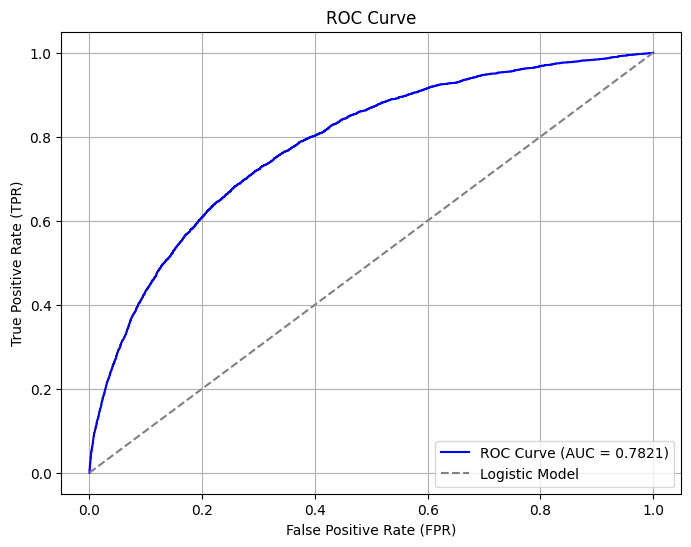

In [28]:
fpr, tpr, thresholds = roc_curve(y_test, final_model.predict_proba(test_scaled)[:, 1])


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Logistic Model')  # Đường chéo ngẫu nhiên
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [44]:
lg=LogisticRegression()
lg.fit(train_scaled, y_train)

# Validation metrics
roc_auc_initial = roc_auc_score(y_test, lg.predict_proba(test_scaled)[:, 1])
fpr_initial, tpr_initial, thresholds_initial = roc_curve(y_test, lg.predict_proba(test_scaled)[:, 1])

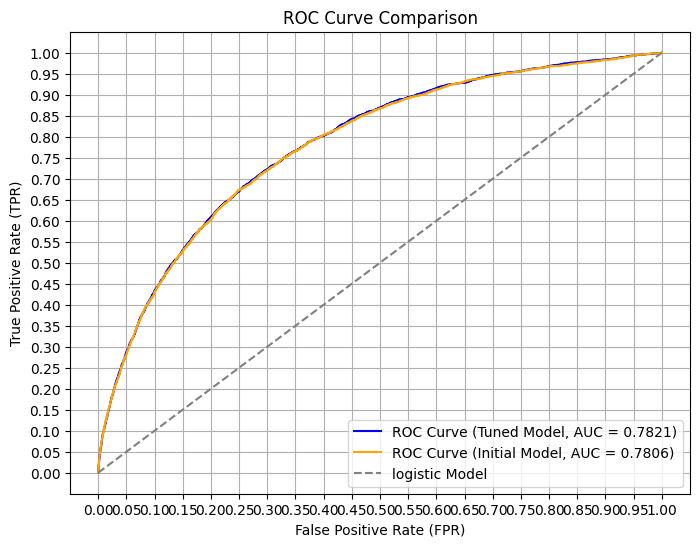

In [50]:
# Vẽ ROC curve cho cả hai model
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (Tuned Model, AUC = {roc_auc:.4f})')
plt.plot(fpr_initial, tpr_initial, color='orange', label=f'ROC Curve (Initial Model, AUC = {roc_auc_initial:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='logistic Model')  # Đường chéo ngẫu nhiên

plt.xticks(np.arange(0, 1.05, 0.05))  
plt.yticks(np.arange(0, 1.05, 0.05))

# Thiết lập các thông số cho đồ thị
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [20]:
test_ss=scaler.fit_transform(test_df)

In [21]:
submission4=final_model.predict_proba(test_ss)
submit4 = pd.Series(data=submission4[:,0], index=sk_id_curr)
submit4.rename('TARGET',inplace=True)
submit4.index.name = 'SK_ID_CURR'
#joblib.dump(final_model,'elasticnet0.2.joblib')
submit4.to_csv('elasticnet0.1.csv', index=True)